In [ ]:
#!pip install geopandas
#!pip install mapclassify
#!pip install termcolor

In [1]:
# Super Market Management System
from mysql.connector import connect, Error
from getpass import getpass
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from termcolor import colored
from IPython.display import display, Image
from datetime import date

import warnings
warnings.filterwarnings('ignore')

In [2]:
# for text bold
b_s = "\033[1m" # to start bold characters
b_e = "\033[0;0m" # to end bold characters

Enter password········


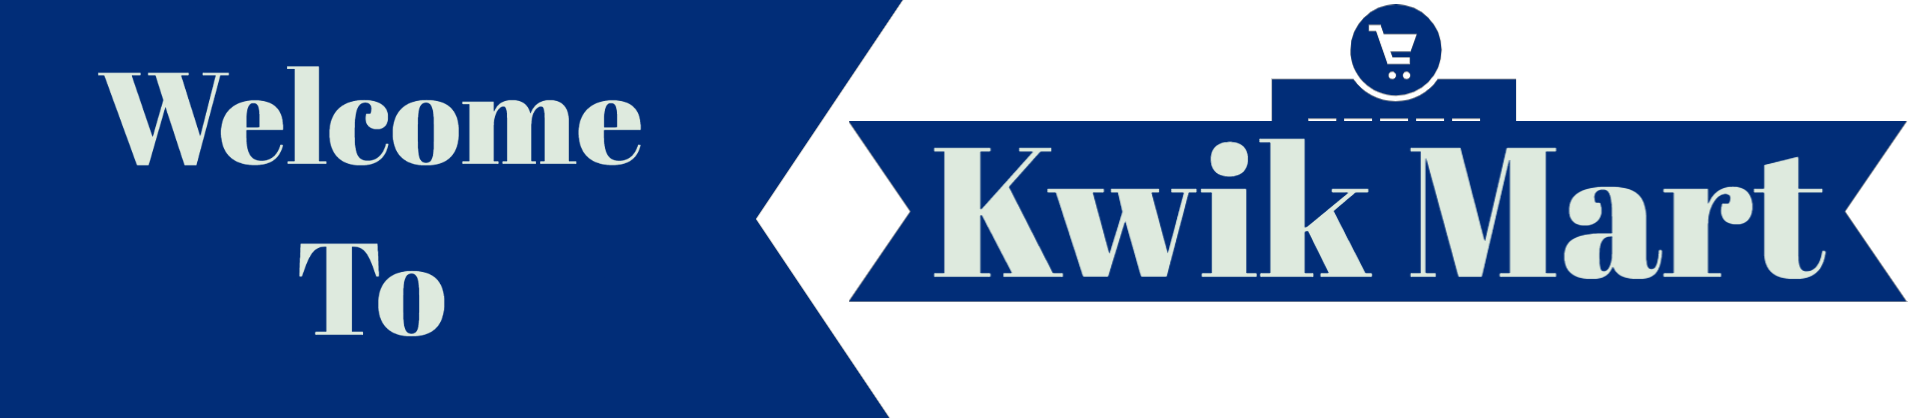

In [13]:
# establishing the connection
try:
        conn = connect(
            host='localhost',
            user='root',
            password=getpass(b_s+'Enter password'+b_e),
            database='kwikmart'
        );
        display(Image(filename='Kwik Mart banner.png'))
except Error as e:
        print(e)

## Some data trends at Kwik Mart

### Looking at the category wise revenue across all stores

In [ ]:
def getCategoriesRevenue(conn, start_date, end_date):
    query='''
    SELECT c.category_name AS Category_Name ,SUM(bi.quantity * bi.net_price) AS Revenue
    FROM bill b
    JOIN bill_items bi ON bi.bill_id = b.bill_id
        AND b.bill_date >= %s and b.bill_date <= %s
    JOIN item i ON i.item_id = bi.item_id
    JOIN category c ON c.category_id = i.category_id
    GROUP BY Category_Name
    ORDER BY Revenue DESC
    ''';
    
    # function to add value labels
    def addlabels(x,y):
        for i in range(len(x)):
            amt = '$'+str(math.trunc(y[i]))
            plt.text(i, y[i]//4, amt, ha = 'center',
                     bbox = dict(facecolor = 'white', alpha =.8),
                    rotation = 90)
        
    value_tuple=(start_date, end_date);
    df = pd.read_sql(query, conn, params=[start_date, end_date])
    plt.figure(figsize=(15, 5))
    plt.bar(df.Category_Name, df.Revenue)
    plt.xticks(rotation=90)
    
    addlabels(df.Category_Name, df.Revenue)
    
    # Add labels and a title.
    plt.xlabel('Categories', labelpad=10, color='#333333',weight='bold')
    plt.ylabel('Net Revenue', labelpad=10, color='#333333',weight='bold')
    plt.title(f'Category wise revenue between [{start_date} , {end_date}]', pad=15, color='#333333',weight='bold')

    plt.show()

In [ ]:
# calling getCategoriesRevenue function
print(b_s+"Category wise sales across all stores, please enter the date range:"+b_e)
cat_rev_start = input(b_s+"From date: "+b_e)
cat_rev_end = input(b_s+"Till date: "+b_e)
getCategoriesRevenue(conn, cat_rev_start, cat_rev_end)
#2022-01-01 | 2022-12-31

### State wise no of stores and revenue 

In [ ]:
def numOfstoresVsRevenue(conn):
    query1 = '''
    Select t1.state, t1.numOfStores, t2.revenue from
    (select count(*) as numOfStores, store.state
    from store
    group by store.state
    order by store.state) t1 join 
    (    select store.state, SUM(revenue) as revenue
    from store left outer join (
    select bill.store_id, Sum(bill_items.quantity * bill_items.net_price) as revenue
    from bill, bill_items
    where bill.bill_id = bill_items.bill_id
    group by bill.store_id) temp
    on store.store_id = temp.store_id
    group by store.state) t2
    where t2.state = t1.state
    order by t1.numOfStores
    ''';
    
    df = pd.read_sql(query1, conn);
    return df

In [ ]:
# calling function
df = numOfstoresVsRevenue(conn)
df.rename(columns={"state": "NAME"},inplace=True)
di = {"SouthDakota":"South Dakota", "WestVirginia":"West Virginia", "RhodeIsland":"Rhode Island", "NewHampshire":"New Hampshire", 
                "NewMexico":"New Mexico", "NorthDakota": "North Dakota","NewJersey":"New Jersey"}
df = df.replace({"NAME": di})

# getting latitude and longitude for each state
df_lat_long = pd.read_csv("US_States_lat_lon_final.csv")
df_states = df_lat_long.merge(df,on='NAME',how='outer')
df_states[["numOfStores","revenue"]] = df_states[["numOfStores","revenue"]].fillna(0)
df_states.head()

In [ ]:
# url of our shape file 
path=r"C:\Users\agraw\Documents\Git\DS5110\Python implementation\cb_2018_us_state_20m"
# load the shape file using geopandas
geo_usa = gpd.read_file(path+'\cb_2018_us_state_20m.shp')

# merge usa_state data and geo_usa shapefile
geo_merge=geo_usa.merge(df_states,on='NAME',how='outer')

indexRow = geo_merge[ (geo_merge.NAME == 'Alaska') | (geo_merge.NAME == 'Hawaii') | (geo_merge.NAME == 'Puerto Rico')].index
geo_merge.drop(indexRow , inplace=True)
geo_merge.reset_index(drop=True, inplace=True)

# plot state wise number of stores
geo_merge.plot(column='numOfStores', figsize=(25, 15),legend=True,cmap='summer')
plt.xlim(-130,-60)
plt.ylim(20,55)
# add countries names and numbers 
for i in range(len(geo_merge)):
    plt.text(geo_merge.lon[i],geo_merge.lat[i],"{}\n   {}".format(geo_merge.NAME[i],int(geo_merge.numOfStores[i])),size=10)
plt.title('Number of stores by States',pad=25,fontsize=25)
plt.show()

In [ ]:
# plot state wise revenue
geo_merge.plot(column='revenue',scheme="quantiles", figsize=(25, 15),legend=True,cmap='summer')
plt.xlim(-130,-60)
plt.ylim(20,55)
# add countries names and numbers 
for i in range(len(geo_merge)):
    plt.text(geo_merge.lon[i],geo_merge.lat[i],\
             "\n{}\n ${}".format(geo_merge.NAME[i],int(geo_merge.revenue[i])),size=10)
plt.title('Revenue by States',pad=25,fontsize=25)
plt.show()

### Quarter-wise business performance based on Revenue

In [ ]:
def revenueInEachQuarter(conn, year):
    query='''
    SELECT CEILING(MONTH(b.bill_date)/3) AS quarter, SUM(bi.net_price*bi.quantity) net_revenue
    FROM bill_items bi
    JOIN bill b ON b.bill_id = bi.bill_id
    WHERE b.bill_date LIKE %s
    GROUP BY 1
    ORDER BY quarter
    ''';
    
    value_tuple = (year+'%',)
    df = pd.read_sql(query, conn,params = value_tuple)
    idx = df[['net_revenue']].idxmax()
    myexplode = np.zeros(len(df.quarter))
    myexplode[idx[0]] = 0.1
    
    plt.figure(figsize=(7, 7))
    plt.pie(df.net_revenue, labels = df.quarter,autopct='%.0f%%', explode = myexplode)
    plt.title(f'Quarterly Revenue for year {year}',pad=10,fontsize=15)

    plt.show()

In [ ]:
# pie-chart to visulize quarterly performance
qtr_year = input(b_s+"Quarterly performance, please enter the year: "+b_e)
revenueInEachQuarter(conn,qtr_year)

## Working with views, functions and stored procedures

### Views

#### 1) Employee Details: This view has only the basic details of all the active employees across all the stores. All the sensetive informations such as salary, SSN number, and higher level employess (CEO's) information has been hidden.

In [ ]:
query='''
    SELECT * FROM kwikmart.employee_details
    ''';
df = pd.read_sql(query, conn)
df

#### 2) Current month's store revenue: This view helps the upper management to track the current month's revenue along with the previous day revenue across all the stores. 

In [ ]:
query='''
    SELECT * FROM kwikmart.current_month_store_revenue
    ''';
df = pd.read_sql(query, conn)
df

### Functions

#### 1) Net revenue for a particular store in a given date range: This helps each store track their performance across months or days.

In [14]:
cursor = conn.cursor()

In [ ]:
func = "SELECT store_billing(%s, %s, %s)"
store_id = input(b_s+"Please enter store id: ")
start_date = input(b_s+"From date: ")
end_date = input(b_s+"Till date: ")

result = cursor.execute(func, [store_id, start_date, end_date])
print(b_s+f"Total revenue for store id {store_id} between {start_date} and {end_date} is: "+b_e, cursor.fetchone()[0],)

# 1 | 2022-01-01 | 2022-12-31

#### 2) Update discount for product: This function let store manager create new discount or update the previous discounts along with an option to make it active or inactive

In [15]:
store_id = input(b_s+"Please enter store id: ")
item_id = input(b_s+"Please enter item id: ")

query='''
    SELECT * FROM kwikmart.discount
    WHERE store_id = %s AND item_id = %s
    ''';
df = pd.read_sql(query, conn, params= [store_id, item_id])

if df.empty:
    print(b_s+f"The discount for item id {item_id} does not exist. Please add the discount in next step. ")
else:
    display(df)
    
#1 1 | 285

Please enter store id: 1
Please enter item id: 285


,store_id,item_id,percent_off,is_active
0,1,285,0.0,0


In [16]:
func = "SELECT update_discount(%s, %s, %s, %s)"
percent_off = input(b_s+"Please enter discount %: ")
is_active = input(b_s+"Please enter 1 to make discount live and 0 to remove discount: ")

result = cursor.execute(func, [store_id, item_id, percent_off, is_active])
print(cursor.fetchone())

df = pd.read_sql(query, conn, params= [store_id, item_id])
conn.commit()
df

Please enter discount %: 1
Please enter 1 to make discount live and 0 to remove discount: 1
(1,)


,store_id,item_id,percent_off,is_active
0,1,285,1.0,1


#### 3) Net revenue for all stores in a given date range: This helps track their performance across months or days.

In [17]:
func = "SELECT overall_billing(%s, %s)"
start_date = input(b_s+"From date: ")
end_date = input(b_s+"Till date: ")

result = cursor.execute(func, [start_date, end_date])
print(b_s+f"Total revenue for all stores between {start_date} and {end_date} is: "+b_e, cursor.fetchone()[0],)

# 2022-01-01 | 2022-12-31

From date: 2022-01-01
Till date: 2022-12-31
Total revenue for all stores between 2022-01-01 and 2022-12-31 is:  38542


#### 4) Create new bill: This function initiates a new bill and generate a bill_id in bill table.

In [18]:
#create bill
func = "SELECT create_bill(%s, %s, %s)"
store_id = input(b_s+"Please enter store id: ")
phone_no = input(b_s+"Please enter phone number: ")
dt = date.today()
date_ = dt.strftime("%Y-%m-%d")

result = cursor.execute(func, [store_id, phone_no, date_])
bill_id = cursor.fetchone()[0]
print(b_s+f"Bill id {bill_id} generated. ")

conn.commit()
# 1 | 100-736-5070

Please enter store id: 1
Please enter phone number: 
Bill id 194 generated. 


In [11]:
conn.close()
cursor.close()

True

In [10]:
conn.commit()

In [ ]:
phone_no

In [ ]:
type(date)

In [19]:
query='''
    SELECT * FROM kwikmart.bill
    ''';
df = pd.read_sql(query, conn)
df

,bill_id,store_id,registered_phone,bill_date
0,1,26,None,2022-01-02
1,2,79,101-797-7932,2022-01-04
2,3,63,289-659-0900,2022-12-08
3,4,34,931-615-0109,2022-01-08
4,5,66,None,2022-01-21
...,...,...,...,...
178,179,28,837-379-0229,2022-11-20
179,180,4,867-634-6426,2022-11-26
180,192,1,None,2022-12-04
181,193,1,100-736-5070,2022-12-04


In [ ]:
conn

In [ ]:
cursor.close()